### LoRA Based Fine-Tuning of Qwen 2.5 for Time-Series Forecasting 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import transformers
import os
import random
import h5py
import pandas as pd
import time
import importlib
from pprint import pprint
import torch 
from tqdm import tqdm
from utils.qwen import load_qwen
import re
import gc

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

c:\Users\Alik\Desktop\M_year\MPhil\Lent\DL\Coursework\am3353\m2-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_state = 28
np.random.seed(random_state)

In [44]:
train_split = 0.8
time_step_split = 0.8

In [4]:
file_path = "data/lotka_volterra_data.h5"  # Change this to the correct path

In [47]:
with h5py.File(file_path, "r") as f:
    # Print the dataset keys
    print("Keys in HDF5 file:", list(f.keys()))
    time_data, traj_data = f[list(f.keys())[0]][:], f[list(f.keys())[-1]][:]

Keys in HDF5 file: ['time', 'trajectories']


##### Need to find which axes are of prey (0) and predator (1)

In [48]:
data_prey, data_pred = traj_data[:, :, 0], traj_data[:, :, -1]

data_prey, data_prey_true = data_prey[:, :int(time_step_split*data_prey.shape[-1])], data_prey[:, int(time_step_split*data_prey.shape[-1]) - 1:]
data_pred, data_pred_true = data_pred[:, :int(time_step_split*data_pred.shape[-1])], data_pred[:, int(time_step_split*data_pred.shape[-1]) - 1:]
time_data_past, time_data_true = time_data[:int(time_step_split*time_data.shape[0])], time_data[int(time_step_split*time_data.shape[0]) - 1:]

print(data_prey_true.shape, data_pred_true.shape)
print(time_data_past.shape, time_data_true.shape, data_prey.shape, data_pred.shape)


### Shuffling by reference?
# np.random.shuffle(data_prey_train)
# np.random.shuffle(data_pred_train)


# print('------ train-test-shape ------')
# print(data_prey_train.shape, data_prey_test.shape)
# print(data_pred_train.shape, data_pred_test.shape)

(1000, 21) (1000, 21)
(80,) (21,) (1000, 80) (1000, 80)


In [7]:
check_rn = random.randint(0, len(data_prey))

#### Evolution

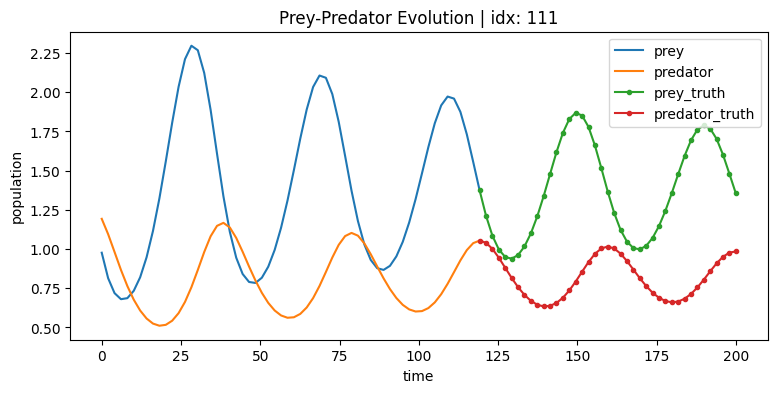

In [45]:
fig = plt.figure(figsize=(9, 4))

plt.plot(time_data_past, data_prey[check_rn], label = 'prey')
plt.plot(time_data_past, data_pred[check_rn], label = 'predator')

plt.plot(time_data_true, data_prey_true[check_rn], label = 'prey_truth', marker = '.')
plt.plot(time_data_true, data_pred_true[check_rn], label = 'predator_truth', marker = '.')

plt.xlabel('time')
plt.ylabel('population')

plt.legend()
plt.title(f'Prey-Predator Evolution | idx: {check_rn}')
plt.show()

#### Qwen 2.5 (Untrained) - Zero Shot Forecasting

Qwen's Interfacing

```
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-0.5B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

```

In [9]:
ft = time.time()
model, tokenizer = load_qwen()
lt = time.time()

print('time-taken: ', (lt - ft)/60, 'mins') 

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


time-taken:  0.08101946910222371 mins


In [10]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

##### LLMTIME preprocessing scheme (tokenize time-series data for Qwen instruct model)

In [11]:
import utils.preprocess
importlib.reload(utils.preprocess)
from utils.preprocess import ts_encoding, ts_decoding

In [36]:
tokenized_prey, offset_prey, scale_prey = ts_encoding(data_prey, model_type="llama", precision=3, alpha=0.99, beta=0.3)
tokenized_pred, offset_pred, scale_pred = ts_encoding(data_pred, model_type="llama", precision=3, alpha=0.99, beta=0.3)

tokenized_prey, offset_prey, scale_prey = tokenized_prey[check_rn], offset_prey[check_rn], scale_prey[check_rn]
tokenized_pred, offset_pred, scale_pred = tokenized_pred[check_rn], offset_pred[check_rn], scale_pred[check_rn]

# print(tokenized_prey.shape, tokenized_pred.shape)
print('----------LLAMA-Encoding-------------')
print('Offsets/Scale-Factors: ', offset_prey.shape, scale_prey.shape)
print('Input: ', data_prey)
print('Tokenized: ', tokenized_prey)

----------LLAMA-Encoding-------------
Offsets/Scale-Factors:  () ()
Input:  [[0.94991744 0.74055135 0.6822457  ... 1.547081   1.6651808  1.8246369 ]
 [0.9714744  1.0787003  1.260828   ... 2.4707153  2.3704321  2.2888165 ]
 [1.0732226  0.8540631  0.7681343  ... 2.3338668  2.364733   2.3909097 ]
 ...
 [1.1288372  1.025194   0.9859951  ... 0.551765   0.64686835 0.80941665]
 [1.1316459  0.80084616 0.6483697  ... 1.641612   1.9831418  2.3758967 ]
 [1.0202591  0.76560074 0.6272315  ... 1.5054415  1.4466231  1.3120288 ]]
Tokenized:  0.375, 0.297, 0.251, 0.233, 0.236, 0.258, 0.3, 0.361, 0.441, 0.541, 0.654, 0.773, 0.882, 0.967, 1.008, 0.994, 0.925, 0.812, 0.678, 0.547, 0.439, 0.36, 0.31, 0.285, 0.282, 0.298, 0.332, 0.383, 0.451, 0.534, 0.628, 0.724, 0.813, 0.882, 0.917, 0.91, 0.86, 0.775, 0.671, 0.565, 0.472, 0.4, 0.353, 0.328, 0.322, 0.335, 0.364, 0.408, 0.467, 0.538, 0.618, 0.698, 0.771, 0.826, 0.853, 0.846, 0.806, 0.737, 0.652, 0.566


### Shouldn't we jointly train prey and predator population <-- Since they are correlated 

##### Seperated Inferencing (we seperately infer the prey and predator population time-series | This messes up the scaling) --- maybe error in encoding
One way to combine is ``` prey_t, pred_t ; prey_t+1, pred_t+1 ...```  | How am I supposed to verify - split the steps in (80,20)

In [ ]:
forecast_length = 21
max_tokens = 512

In [38]:
def create_forecast_prompt_sep(encoded_series, forecast_length=10, name='prey'):

    prompt = f"""<|im_start|>user
    I have a time series representing {name} populations. Each timestep is separated by commas.

    Time series data: {encoded_series}

    Predict exactly {forecast_length} timesteps, following the same pattern and formatting.
    Ensure the output consists of exactly {forecast_length} values, comma-separated, without any additional text or explanation.
    Stop generating after {forecast_length} steps.

    Output format example:
    [value1, value2, ..., value{forecast_length}]

    Strictly follow this format and do not generate more or fewer than {forecast_length} values.
    <|im_end|>
    <|im_start|>assistant
    """
    
    return prompt

def create_forecast_prompt_joint(encoded_series_prey, encoded_series_predator, forecast_length=10, prey_name='prey', predator_name='predator'):
    
    series_length = len(encoded_series_prey.split(', '))
    
    prompt = f"""<|im_start|>user
    I have time series for {prey_name} and {predator_name} populations.

    The data is formatted as: { '; '.join([f'{prey}, {pred}' for prey, pred in zip(encoded_series_prey.split(', '), encoded_series_predator.split(', '))]) };

    Forecast the next {forecast_length} points in the same format:
    {'; '.join([f'{{prey_{series_length + i}}}, {{pred_{series_length + i}}}' for i in range(1, forecast_length + 1)])}

    Generate exactly {forecast_length} pairs IN THE GIVEN FORMAT.
    <|im_end|>
    <|im_start|>assistant
    """

    # prompt = f"""
    # The data is formatted as: { '; '.join([f'{prey}, {pred}' for prey, pred in zip(encoded_series_prey.split(', '), encoded_series_predator.split(', '))]) };
    # Predict next {forecast_length} pairs in same format - prey_1, predator_1; prey_2, predator_2; prey_3, predator_3 ...
    # """

    return prompt

def extract_forecasts(forecast_output, model_type='llama'):
    """
    Given forecast_output in the format:
    0.477, 0.524;\n    0.32, 0.425;\n    0.259, 0.347; ...
    This function extracts and returns two lists: one for prey forecasts and one for predator forecasts.
    """

    # Remove any explicit '\n' escape sequences and extra spaces
    cleaned_output = forecast_output.replace('\\n', '').strip()

    # Regular expression pattern to match pairs of numbers (handles floats and integers)
    pattern = r'([-+]?\d*\.\d+|\d+)\s*,\s*([-+]?\d*\.\d+|\d+)(?=\s*;|$)'
    matches = re.findall(pattern, cleaned_output)

    prey_forecasts = [match[0] for match in matches]
    predator_forecasts = [match[1] for match in matches]

    if model_type == 'llama':
        prey_forecasts = ', '.join(prey_forecasts)
        predator_forecasts = ', '.join(predator_forecasts)

    elif model_type == 'gpt':
        prey_forecasts = ", ".join(" ".join(prey_forecasts))
        predator_forecasts = ", ".join(" ".join(predator_forecasts))

    return prey_forecasts, predator_forecasts


# Generate forecasts
def generate_forecast(encoded_series, tokenizer, forecast_length=10, max_new_tokens=100):

    prompt = create_forecast_prompt_sep(encoded_series, forecast_length)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    # Set parameters for more deterministic generation
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=0.1,  # Low temperature for more deterministic output
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    
    # Extract only the newly generated tokens
    generated_text = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return generated_text.strip()

In [39]:
prey_pred_prompt = create_forecast_prompt_joint(tokenized_prey, tokenized_pred, forecast_length=forecast_length)
pprint(prey_pred_prompt)

('<|im_start|>user\n'
 '    I have time series for prey and predator populations.\n'
 '\n'
 '    The data is formatted as: 0.375, 1.017; 0.297, 0.905; 0.251, 0.775; '
 '0.233, 0.644; 0.236, 0.525; 0.258, 0.425; 0.3, 0.346; 0.361, 0.288; 0.441, '
 '0.251; 0.541, 0.235; 0.654, 0.241; 0.773, 0.271; 0.882, 0.327; 0.967, 0.409; '
 '1.008, 0.517; 0.994, 0.643; 0.925, 0.774; 0.812, 0.89; 0.678, 0.966; 0.547, '
 '0.988; 0.439, 0.954; 0.36, 0.877; 0.31, 0.776; 0.285, 0.668; 0.282, 0.566; '
 '0.298, 0.476; 0.332, 0.402; 0.383, 0.346; 0.451, 0.31; 0.534, 0.293; 0.628, '
 '0.297; 0.724, 0.321; 0.813, 0.368; 0.882, 0.437; 0.917, 0.526; 0.91, 0.628; '
 '0.86, 0.734; 0.775, 0.827; 0.671, 0.891; 0.565, 0.914; 0.472, 0.894; 0.4, '
 '0.838; 0.353, 0.758; 0.328, 0.669; 0.322, 0.582; 0.335, 0.503; 0.364, 0.438; '
 '0.408, 0.388; 0.467, 0.354; 0.538, 0.339; 0.618, 0.342; 0.698, 0.364; 0.771, '
 '0.406; 0.826, 0.466; 0.853, 0.541; 0.846, 0.627; 0.806, 0.713; 0.737, 0.788; '
 '0.652, 0.839; 0.566, 0.858;\n'


##### Untrained Qwen Forecasting

##### Joint

In [40]:
ft = time.time()
prey_pred_response = generate_forecast(prey_pred_prompt, tokenizer, forecast_length=forecast_length, max_new_tokens=max_tokens)
lt = time.time()

print('time-taken: ', (lt - ft) / 60)

time-taken:  2.5943750500679017


In [41]:
print(type(prey_pred_response), len(prey_pred_response), repr(prey_pred_response))

<class 'str'> 660 '0.375, 1.017;\n    0.297, 0.905;\n    0.251, 0.775;\n    0.233, 0.644;\n    0.236, 0.525;\n    0.258, 0.425;\n    0.3, 0.346;\n    0.361, 0.288;\n    0.441, 0.251;\n    0.541, 0.235;\n    0.654, 0.241;\n    0.773, 0.271;\n    0.882, 0.327;\n    0.967, 0.409;\n    1.008, 0.517;\n    0.994, 0.643;\n    0.925, 0.774;\n    0.812, 0.89;\n    0.678, 0.966;\n    0.547, 0.988;\n    0.439, 0.954;\n    0.36, 0.877;\n    0.31, 0.776;\n    0.285, 0.668;\n    0.282, 0.566;\n    0.298, 0.476;\n    0.332, 0.402;\n    0.383, 0.346;\n    0.451, 0.31;\n    0.534, 0.293;\n    0.628, 0.297;\n    0.724, 0.321;\n    0.813, 0.368;\n    0.882, 0.437;\n    0.917, 0.526;\n    0.91, 0.628;\n    0.86, 0.734;\n    0.'


In [42]:
prey_decoded_response, pred_decoded_response = extract_forecasts(prey_pred_response)

print(len(prey_decoded_response), len(pred_decoded_response))
print(prey_decoded_response)

prey_decoded_response = ts_decoding(prey_decoded_response, model_type="llama", precision=3, offsets=offset_prey, scale_factors=scale_prey)[:forecast_length]
pred_decoded_response = ts_decoding(pred_decoded_response, model_type="llama", precision=3, offsets=offset_pred, scale_factors=scale_pred)[:forecast_length]

251 255
0.375, 0.297, 0.251, 0.233, 0.236, 0.258, 0.3, 0.361, 0.441, 0.541, 0.654, 0.773, 0.882, 0.967, 1.008, 0.994, 0.925, 0.812, 0.678, 0.547, 0.439, 0.36, 0.31, 0.285, 0.282, 0.298, 0.332, 0.383, 0.451, 0.534, 0.628, 0.724, 0.813, 0.882, 0.917, 0.91, 0.86


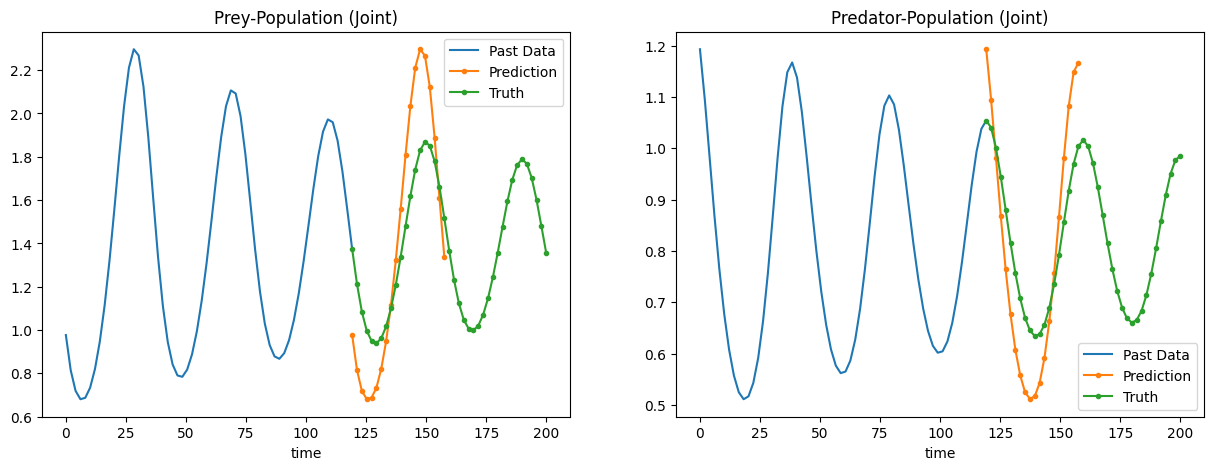

In [43]:
# diff = abs(time_data[0] - time_data[1])

# time_test_data = []
# tmp = time_data[-1]
# for _ in range(len(prey_decoded_response)):
#     tmp += diff
#     time_test_data.append(tmp)

fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(time_data_past, data_prey[check_rn].tolist(), label = 'Past Data')
axs[0].plot(time_data_true[:len(prey_decoded_response)], prey_decoded_response, label = 'Prediction', marker = '.')
axs[0].plot(time_data_true, data_prey_true[check_rn].tolist(), label = 'Truth', marker = '.')

axs[0].set_title('Prey-Population (Joint)')
axs[0].set_xlabel('time')
axs[0].legend()

axs[1].plot(time_data_past, data_pred[check_rn].tolist(), label = 'Past Data')
axs[1].plot(time_data_true[:len(prey_decoded_response)], pred_decoded_response, label = 'Prediction', marker = '.')
axs[1].plot(time_data_true, data_pred_true[check_rn].tolist(), label = 'Truth', marker = '.')

axs[1].set_title('Predator-Population (Joint)')
axs[1].set_xlabel('time')
axs[1].legend()

plt.show()

# print()

# plt.plot(time_data_past, data_prey[check_rn].tolist(), label = 'Past Data')
# plt.plot(time_data_true, prey_decoded_response, label = 'Prediction', marker = '.')
# plt.plot(time_data_true, data_prey_true[check_rn].tolist(), label = 'Truth', marker = '.')

# plt.plot(time_data_past, data_pred[check_rn].tolist(), label = 'Past Data')
# plt.plot(time_data_true, pred_decoded_response, label = 'Prediction', marker = '.')
# plt.plot(time_data_true, data_pred_true[check_rn].tolist(), label = 'Truth', marker = '.')

# plt.xlabel('time')
# plt.title('Prey-Predator-Population (Joint)')
# plt.legend()
# plt.show()


##### LoRA pre-training (we low-rank train the query and value projection matrices - retrain the attention networks)

In [49]:
import utils.lora
import utils.preprocess
importlib.reload(utils.lora)
importlib.reload(utils.preprocess)

from utils.lora import LoRALinear
from utils.preprocess import process_sequences
from utils.preprocess import ts_encoding, ts_decoding
from torch.utils.data import TensorDataset, DataLoader


# from torchsummary import summary

In [63]:
batch_size = 8
learning_rate = 1e-5
lora_rank = 2
max_ctx_length = 512

In [53]:
# Apply LoRA to the model:
### replacing attention layers with trainable layers (r * in_dim) + (out_dim * r)
for layer in model.model.layers:
    layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank) 
    layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank)

##### Joint Training

In [54]:
encoded_prey, offset_prey, scale_prey = ts_encoding(data_prey, model_type="llama", precision=3, alpha=0.99, beta=0.3)
encoded_pred, offset_pred, scale_pred = ts_encoding(data_pred, model_type="llama", precision=3, alpha=0.99, beta=0.3)

In [55]:
prey_pred_encoded = []
for token_prey, token_pred in zip(encoded_prey, encoded_pred):
    prey_pred_encoded.append(create_forecast_prompt_joint(tokenized_prey, tokenized_pred, forecast_length=forecast_length))

prey_pred_encoded = np.array(prey_pred_encoded)
print(prey_pred_encoded.shape)

del tokenized_prey, tokenized_pred
gc.collect() 

(1000,)


9442

In [56]:
data_train, data_test = prey_pred_encoded[:int(train_split * len(prey_pred_encoded))], prey_pred_encoded[int(train_split * len(prey_pred_encoded)):]  
print(data_train.shape, data_test.shape)

(800,) (200,)


In [64]:
train_input_ids = process_sequences(data_train, tokenizer, max_ctx_length, stride=max_ctx_length // 2)
val_input_ids = process_sequences(data_test, tokenizer, max_ctx_length, stride=max_ctx_length)

train_dataset = TensorDataset(train_input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [65]:
for batch in train_loader:
    print(batch[0].shape)
    break

torch.Size([8, 512])


In [66]:
optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=learning_rate)

In [67]:
def get_model_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total, trainable = get_model_params(model)
print(f"Total Parameters: {total:,}")
print(f"Trainable Parameters: {trainable:,}") ## 100x lesser


Total Parameters: 494,319,872
Trainable Parameters: 287,104


In [1]:
# # Prepare components with Accelerator
# accelerator = Accelerator()
# model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

model.train()

steps = 0
progress_bar = tqdm(range(100), desc="Training Steps")
while steps < 100:
    for (batch,) in train_loader:
        optimizer.zero_grad()
        outputs = model(batch, labels=batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        steps += 1
        progress_bar.update(1)
        progress_bar.set_postfix(loss=loss.item())

        if steps >= 100:
            break

model.eval()

NameError: name 'model' is not defined

#### Joint Training